# Présentation

# TP6

### Consigne ###

1. Importer les points
2. Compter le nombre de points par niveau administratif 
3. A partir des points, créer un raster de 5km par pixel (regrouper les points)
4. Visualiser les rasters sous forme de catégories

### ***Importation des librairies***

In [94]:
# Nous commençons par importer toutes les library nécessaires (7)


import pandas as pd  # gestion des données
import geopandas as gpd  # manipuler des données géospatiales
import rasterio  # lecture et écriture de fichiers raster
from rasterio.transform import from_origin  # fonction pour créer une transformation affine pour les rasters
import matplotlib.pyplot as plt  # visualisation graphique
import numpy as np  # pour le calcul numérique
from shapely.geometry import Point  # travailler avec des objets géométriques de type point
import os  # interagir avec le système de fichiers (chemins, fichiers, etc.)
import folium  # cartes interactives 
from folium import plugins  # plugins supplémentaires de folium pour enrichir les cartes
from folium import raster_layers  # ajouter des couches raster à une carte folium
from branca.colormap import linear  # pour créer des palettes de couleurs linéaires dans folium

### ***1. Importer les points contenus dans le fichier Points_data.csv et filtrer uniquement le pays qui nous intéresse : le Burkina Faso***

In [95]:

# 1. Importer les points contenus dans le fichier Points_data.csv et filtrer uniquement le pays qui nous intéresse : le Burkina Faso
path = r"C:\Users\HP\OneDrive\1231116193333-Desktop\Desktop\ISEP3\Stat_spatiales" #Chemin relatif
file = "Points_data.csv"
data = pd.read_csv(os.path.join(path, file))
burkina_points = data[data['event_id_cnty'].str.startswith('BFO')] # Filtre
print(f"Le nombre de points du Burkina Faso : {len(burkina_points)}") # Checking
print(burkina_points.head(2)) # 2 lignes suffisent comme il y a beaucoup de colonnes
chemin_shapefile = "C:/Users/HP/OneDrive/1231116193333-Desktop/Desktop/bfa_adm_igb_20200323_shp/bfa_admbnda_adm0_igb_20200323.shp"

Le nombre de points du Burkina Faso : 11392
  event_id_cnty       event_date  year  time_precision       disorder_type  \
1      BFO12659  04 October 2024  2024               1  Political violence   
2      BFO12661  04 October 2024  2024               1  Political violence   

                   event_type    sub_event_type  \
1  Explosions/Remote violence  Air/drone strike   
2                     Battles       Armed clash   

                                         actor1 assoc_actor_1        inter1  \
1       Military Forces of Burkina Faso (2022-)           NaN  State forces   
2  JNIM: Group for Support of Islam and Muslims           NaN   Rebel group   

   ...     location latitude longitude geo_precision                source  \
1  ...  Dida Forest  10.0116   -4.0287             2    Undisclosed Source   
2  ...        Djibo  14.0875   -1.6418             2  Al Zallaqa; Whatsapp   

          source_scale                                              notes  \
1  Local partner-

 ### ***2. Compter le nombre de points par niveau admin (pays, région, provine et commune)***

In [96]:
# 2. Compter le nombre de points par niveau admin (pays, région, provine et commune)


# Comptage
count_pays = burkina_points['country'].value_counts() #country = pays (admin0 lors des TP précédents)
count_region = burkina_points['admin1'].value_counts() #admin1=région
count_departement = burkina_points['admin2'].value_counts() #admin2=province ou département
count_commune = burkina_points['admin3'].value_counts() # admin3=district ou commune

# Affichage 
print("Nombre de points du pays :\n", count_pays)
print("Nombre de points par région :\n", count_region)
print("\nNombre de points par département :\n", count_departement)
print("\nNombre de points par commune :\n", count_commune)


# Exportation des comptages sous format CSV
count_pays.to_csv('points_pays.csv', index=True, header=['Nombre de points'])
count_region.to_csv('points_region.csv', index=True, header=['Nombre de points'])
count_departement.to_csv('points_departement.csv', index=True, header=['Nombre de points'])
count_commune.to_csv('points_commune.csv', index=True, header=['Nombre de points'])

print("Exportation terminée : Les fichiers CSV sont créés.")



Nombre de points du pays :
 country
Burkina Faso    11392
Name: count, dtype: int64
Nombre de points par région :
 admin1
Sahel                2811
Est                  2195
Centre-Nord          1489
Boucle du Mouhoun    1165
Nord                 1115
Centre                699
Centre-Est            588
Hauts-Bassins         435
Cascades              354
Sud-Ouest             225
Centre-Ouest          190
Centre-Sud             84
Plateau-Central        42
Name: count, dtype: int64

Nombre de points par département :
 admin2
Soum           1057
Oudalan         783
Gourma          721
Sanmatenga      705
Kadiogo         699
Tapoa           607
Seno            602
Yatenga         599
Bam             451
Kossi           408
Yagha           369
Loroum          348
Koulpelogo      341
Comoe           340
Namentenga      333
Kompienga       324
Gnagna          307
Sourou          305
Houet           255
Komandjari      236
Boulgou         211
Poni            160
Mouhoun         155
Nayala    

#### Vérification

In [97]:
#### G O T T A  C H E C K

total_pays = count_pays.sum() # Calcul des totaux
total_region = count_region.sum()
total_departement = count_departement.sum()
total_commune = count_commune.sum()

if total_pays == total_region == total_departement == total_commune: #Vérification
    print("\nLes sommes des points par commune, département, région et pays sont bien égales et sont égales à 11 392 points.")
else:
    print("\n Désolée, il y a eu incohérence dans les sommes des points :")
    if total_pays != total_region:
        print(f" - Différence entre pays ({total_pays}) et région ({total_region})")
    if total_region != total_departement:
        print(f" - Différence entre région ({total_region}) et département ({total_departement})")
    if total_departement != total_commune:
        print(f" - Différence entre département ({total_departement}) et commune ({total_commune})")



Les sommes des points par commune, département, région et pays sont bien égales et sont égales à 11 392 points.


### ***3. A partir des points, créer un raster de 5km par pixel (regrouper les points) // En 5 étapes***

In [98]:
#3. A partir des points, créer un raster de 5km par pixel (regrouper les points) // En 5 étapes


geometry = [Point(xy) for xy in zip(burkina_points['longitude'], burkina_points['latitude'])] # First step : on convertit les points en GeoDataFrame
gdf = gpd.GeoDataFrame(burkina_points, geometry=geometry)

#Etape2 : les paramètres du raster
pixel_size = 5000/111320  # 5 km =5000 m converti en degré vue que les x et y sont en degrés. A l'inverse, on aurait pu convertir ces derniers en m
xmin, ymin, xmax, ymax = gdf.total_bounds  # on cherche à encadrer le pays en récupérant, les coordonnées maximales
width = int((xmax - xmin) / pixel_size)  # largeur du raster
height = int((ymax - ymin) / pixel_size)  # hauteur du raster
transform = from_origin(xmin, ymax, pixel_size, pixel_size)  # La fonction from_origin() génère une transformation affine qui permet de convertir les coordonnées géographiques (X, Y) en coordonnées raster (index de ligne et de colonne). 
#En d'autres termes, elle définit la relation entre les coordonnées géographiques de l'image et l'index des pixels dans l'image.
print(width)
print(height)

raster_data = np.zeros((height, width), dtype=int) # Etape3 : raster vide

for point in gdf.geometry: # 4th step : Remplissage de notre raster
    x, y = ~transform * (point.x, point.y) #Transformation inverse (coordonnées rasters e coordonnées géographiques)
    row, col = int(y), int(x)  # les indices de position des rasters // donc forcément en entier 
    if 0 <= row < height and 0 <= col < width:  # Check if the point falls within raster bounds
        raster_data[row, col] += 1  # Incréméntation

with rasterio.open(  #Etape 5 : Enregistrement du raster
    'burkina_tous_points_raster.tiff', 'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=raster_data.dtype,
    crs="EPSG:4326",
    transform=transform
) as dst:
    dst.write(raster_data, 1)

print("Le raster a été créé avec succès sous le nom 'burkina_tous_points_raster.tiff'")
raster_path = 'burkina_tous_points_raster.tiff' #Vérification du contenu de notre raster
with rasterio.open(raster_path) as src:
    # Lire la première bande
    bandeun = src.read(1)  # 1 pour la première bande
    data = src.read(1) 
    profile = src.profile
    transform = src.transform
    crs = src.crs
np.unique(bandeun)


208
297
Le raster a été créé avec succès sous le nom 'burkina_tous_points_raster.tiff'


array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  44,  46,  47,  48,  49,  51,  52,  53,  54,
        58,  59,  60,  61,  62,  65,  66,  70,  81, 110, 116, 138, 152,
       217, 639])

### ***4. Visualiser les rasters sous forme de catégories***

Shapefile reprojeté pour correspondre au CRS du raster.


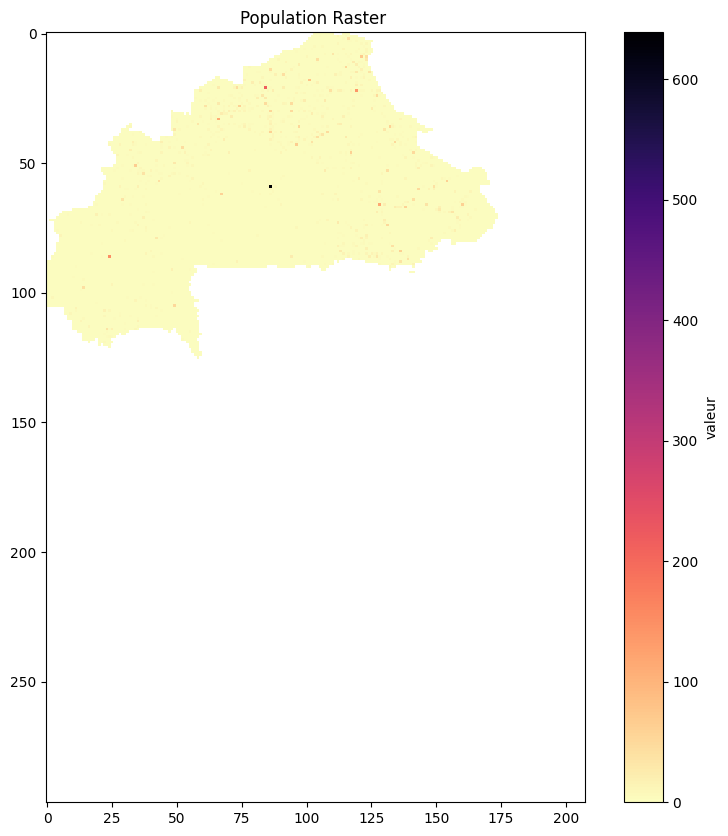

In [99]:
from rasterio.features import geometry_mask
# Lire la première bande
  # Lire la première bande
profile = src.profile
transform = src.transform
crs = src.crs

shapefile = gpd.read_file(chemin_shapefile)
        
# Reprojeter le shapefile si nécessaire
if shapefile.crs != crs:
    shapefile = shapefile.to_crs(crs)
print("Shapefile reprojeté pour correspondre au CRS du raster.")
        
geometries = shapefile.geometry.values  # Extraire les géométries
        
# Créer un masque où les pixels à l'intérieur du shapefile sont True
mask = geometry_mask(
    geometries,
    transform=transform,
    invert=True,
    out_shape=(src.height, src.width)
        )
        
# Appliquer le masque au raster
        
nom_data = np.where(mask, data, np.nan)  # Mettre NaN en dehors du shapefile
        
# 1 pour la première bande
plt.figure(figsize=(10,10))
plt.imshow(nom_data, cmap="magma_r", interpolation ="none") #pour voir l'image
plt.title("Population Raster ")
plt.colorbar(label= "valeur")
plt.show()

In [40]:
#4. Visualiser les rasters sous forme de catégories


raster_path = 'burkina_tous_points_raster.tiff' 
with rasterio.open(raster_path) as src:
    # Lire la première bande
    first_band = src.read(1)

xmin, ymin, xmax, ymax = src.bounds 
center = [(ymin + ymax) / 2, (xmin + xmax) / 2]

m = folium.Map(location=center, zoom_start=10) # la carte avec Folium, centrée sur les coordonnées du raster

min_value, max_value = np.min(first_band), np.max(first_band) # palette de couleurs en fonction de la distribution des valeurs uniques
colormap = linear.Reds_09.scale(min_value, max_value)  # Palette de couleurs pour les valeurs

raster_layer = raster_layers.ImageOverlay(# Ajouter le raster à la carte en tant que couche d'image 
    image=first_band,  
    bounds=[[ymin, xmin], [ymax, xmax]],
    opacity=0.7,
    colormap=colormap
)

raster_layer.add_to(m) # Ajouter la couche

colormap.add_to(m) # Légende

folium.LatLngPopup().add_to(m)  # Afficher les coordonnées de la souris
plugins.Fullscreen().add_to(m)  # Basculement en mode plein écran
plugins.MeasureControl(primaryLengthUnit="kilometers").add_to(m)  # Mesure des distances

m.save('C:/Users/HP/OneDrive/1231116193333-Desktop/Desktop/ISEP3/Stat_spatiales/interactive_map.html') # Afficher la carte
print("Bravo, la carte interactive a été enregistrée sous 'interactive_map.html'.")


Bravo, la carte interactive a été enregistrée sous 'interactive_map.html'.


# Fin du TP6

# TP6 ++

### ***1. Créons un raster de 5km de résolution des évènements (non par type d'événements) pour chaque année***

In [90]:

years = burkina_points['year'].unique()  # Liste des années
rasters = {}  # Dictionnaire pour stocker les rasters par année

pixel_size = 5000 / 111320  # 5 km en degrés
xmin, ymin, xmax, ymax = burkina_points['longitude'].min(), burkina_points['latitude'].min(), burkina_points['longitude'].max(), burkina_points['latitude'].max()
width = int((xmax - xmin) / pixel_size)
height = int((ymax - ymin) / pixel_size)
transform = from_origin(xmin, ymax, pixel_size, pixel_size)

for year in years:
    yearly_data = burkina_points[burkina_points['year'] == year]  #on filtre nos année
    years = burkina_points['year'].unique()  # Liste des année
    rasters = {}  # Dictionnaire pour stocker les rasters par année

pixel_size = 5000 / 111320  # on converti
xmin, ymin, xmax, ymax = burkina_points['longitude'].min(), burkina_points['latitude'].min(), burkina_points['longitude'].max(), burkina_points['latitude'].max()
width = int((xmax - xmin) / pixel_size)
height = int((ymax - ymin) / pixel_size)
transform = from_origin(xmin, ymax, pixel_size, pixel_size)

for year in years:
    yearly_data = burkina_points[burkina_points['year'] == year]  # on Filtre par année
    geometry = [Point(xy) for xy in zip(yearly_data['longitude'], yearly_data['latitude'])]
    gdf = gpd.GeoDataFrame(yearly_data, geometry=geometry)

    #on crée nos raster
    raster_data = np.zeros((height, width), dtype=int)
    for point in gdf.geometry:
        x, y = ~transform * (point.x, point.y)
        row, col = int(y), int(x)
        if 0 <= row < height and 0 <= col < width:
            raster_data[row, col] += 1

    rasters[year] = raster_data  # Stocker le raster dans le dictionnaire

    # on enregistre
    with rasterio.open(
        f'raster_{year}.tif', 'w',
        driver='GTiff',
        height=height,
        width=width,
        count=1,
        dtype=raster_data.dtype,
        crs="EPSG:4326",
        transform=transform
         ) as dst:
              dst.write(raster_data, 1)
              gdf = gpd.GeoDataFrame(yearly_data, geometry=geometry)

# on crée pour cette année
raster_data = np.zeros((height, width), dtype=int)
for point in gdf.geometry:
      x, y = ~transform * (point.x, point.y)
      row, col = int(y), int(x)
      if 0 <= row < height and 0 <= col < width:
          raster_data[row, col]+=1
      rasters[year] = raster_data  # Stocker le raster dans le didictionn
                                                                        # Enregistrement (optionnel)
with rasterio.open(
   f'raster_{year}.tif', 'w',
   driver='GTiff',
   height=height,
   width=width,
   count=1,
   dtype=raster_data.dtype,
   crs="EPSG:4326",
   transform=transform
   ) as dst:
       dst.write(raster_data, 1)


### ***2. Visualisons les rasters***

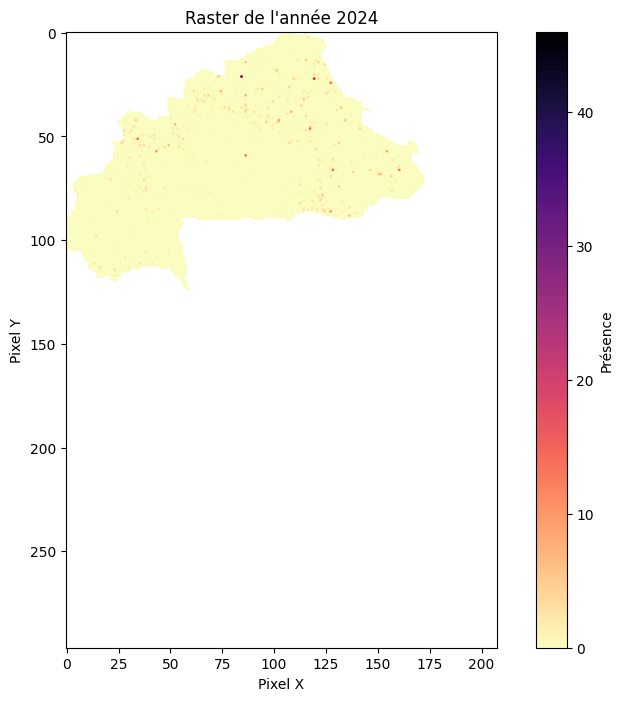

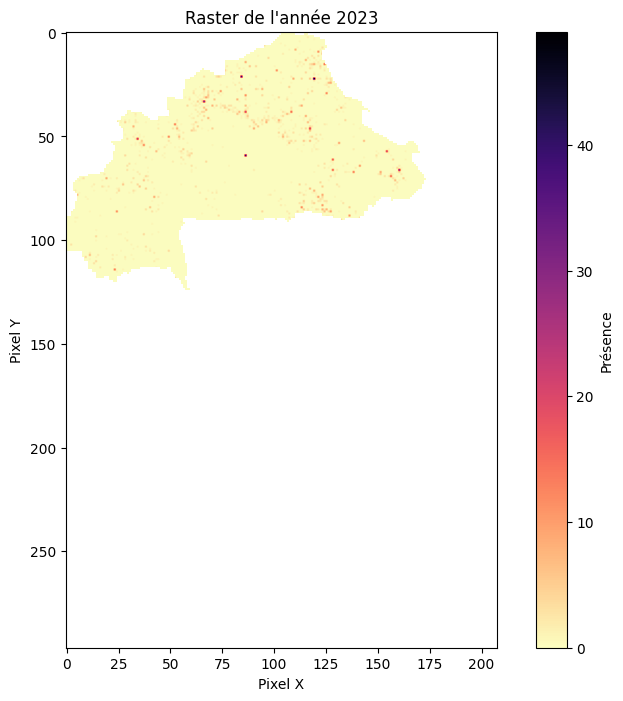

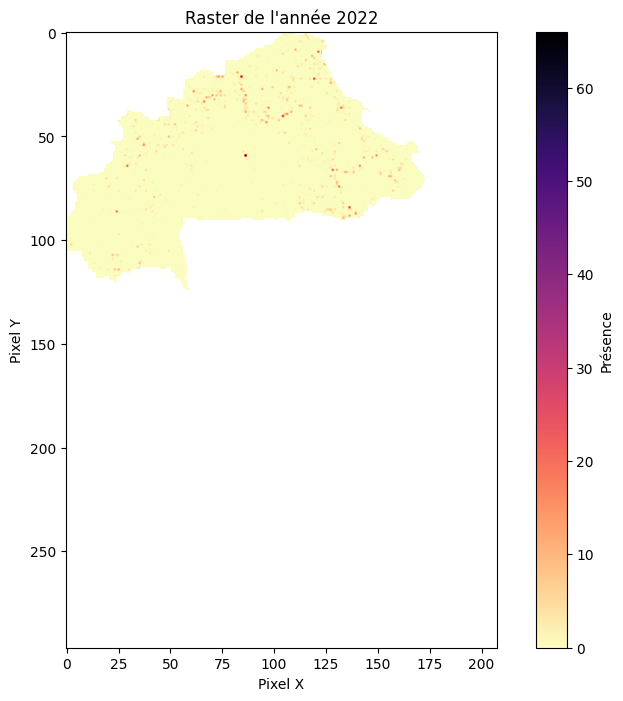

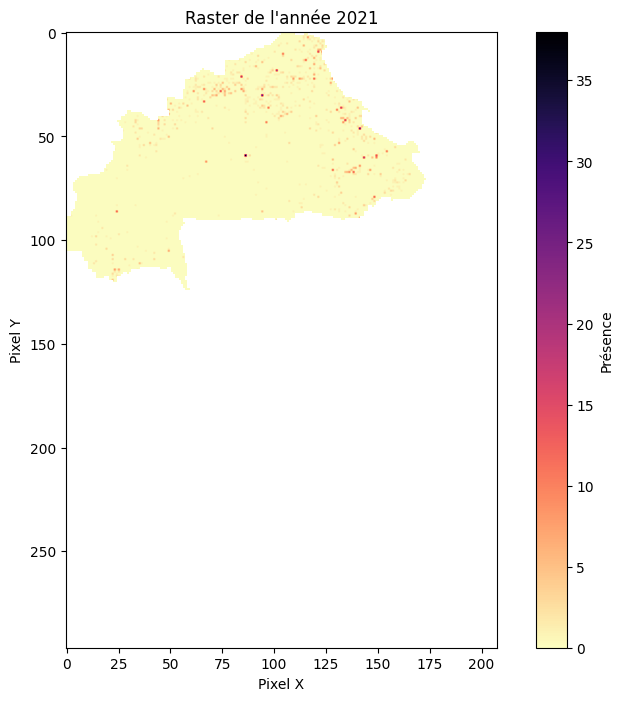

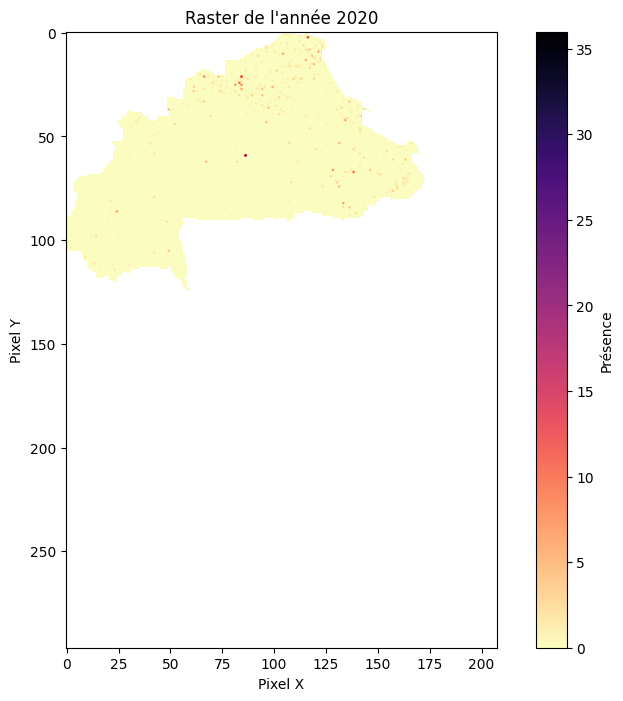

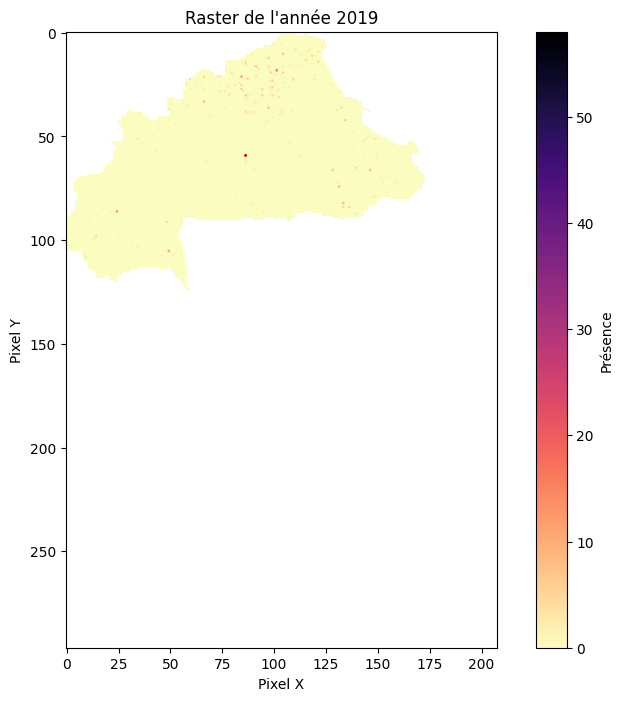

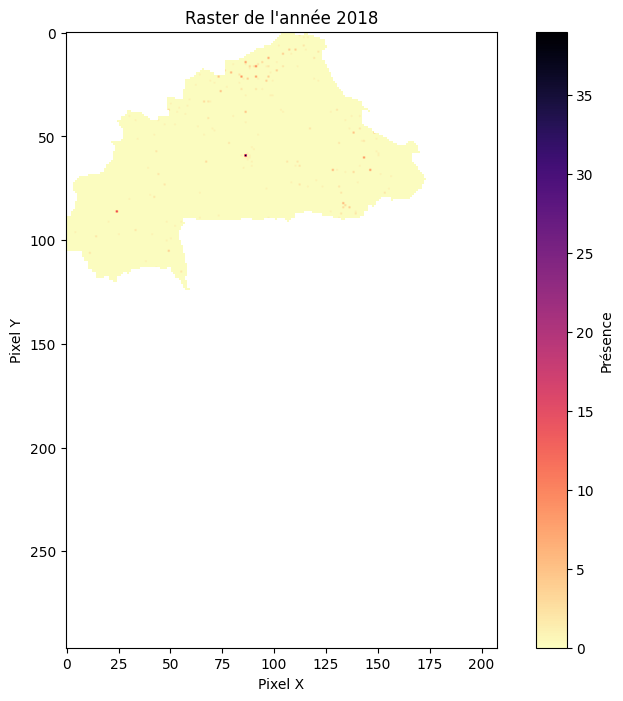

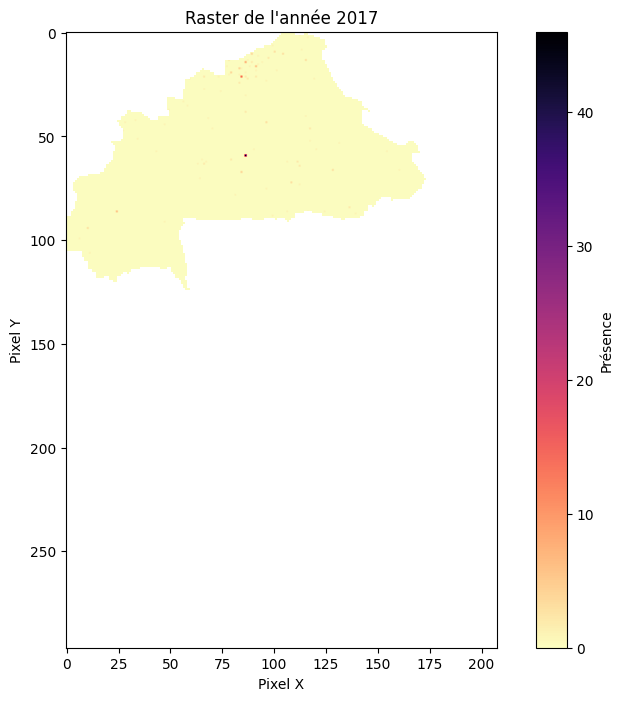

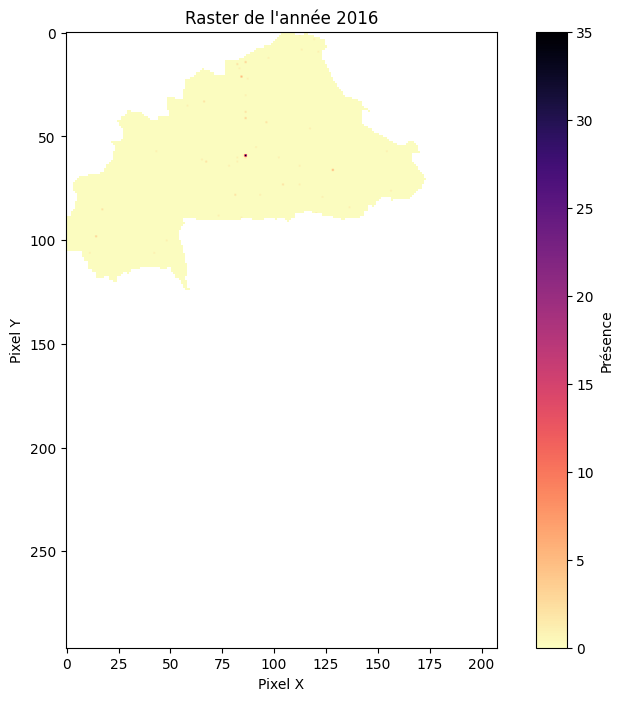

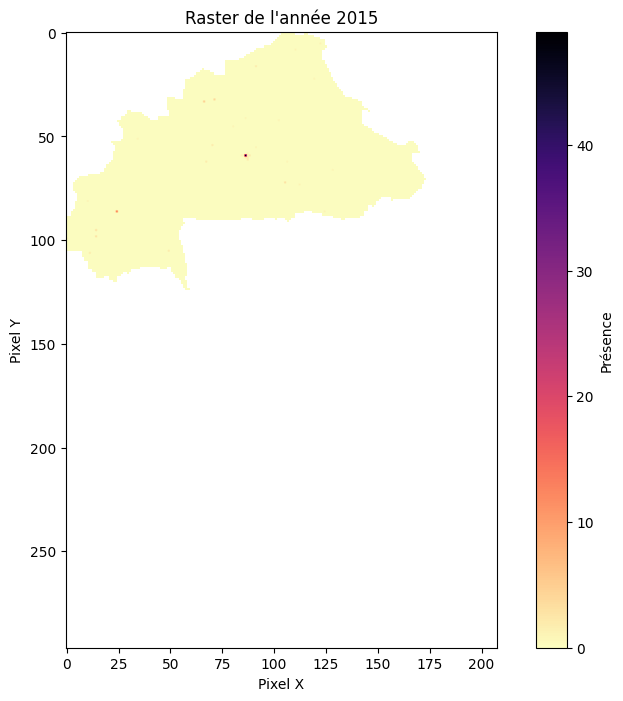

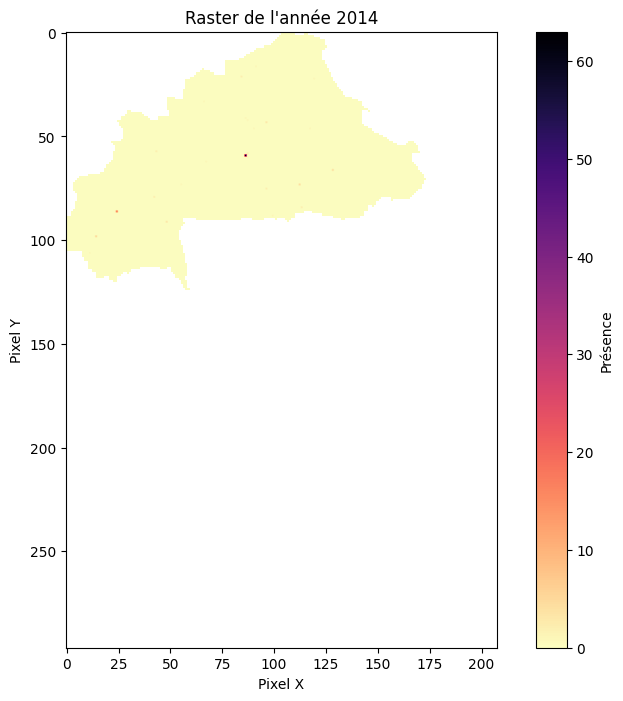

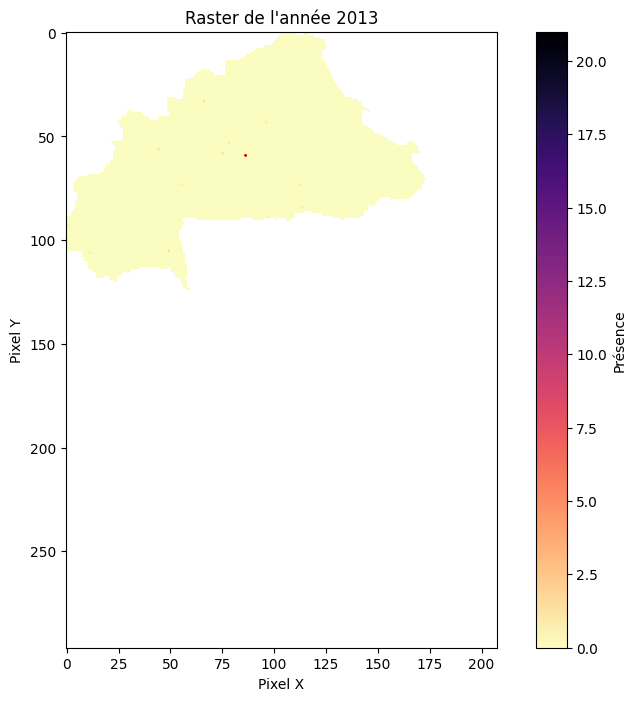

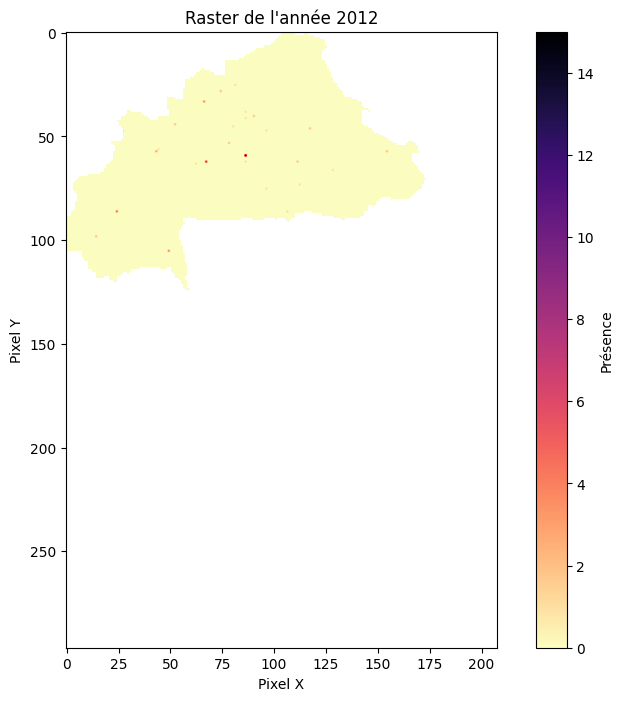

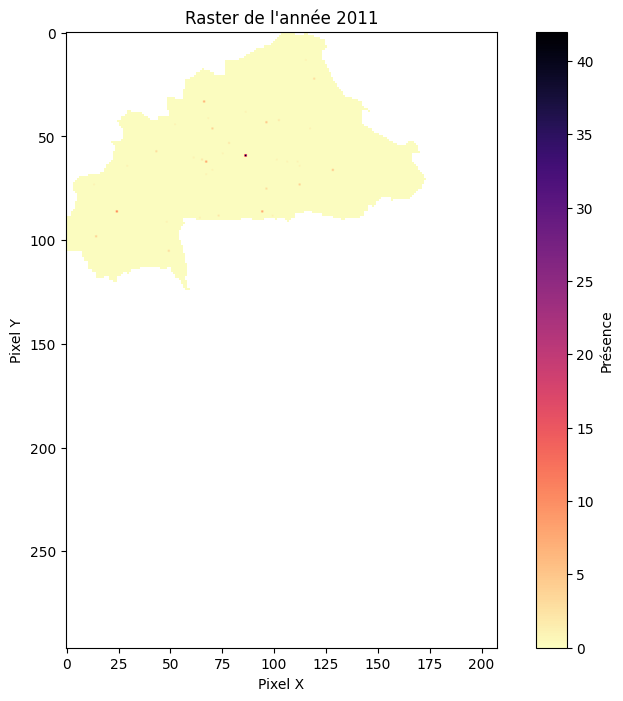

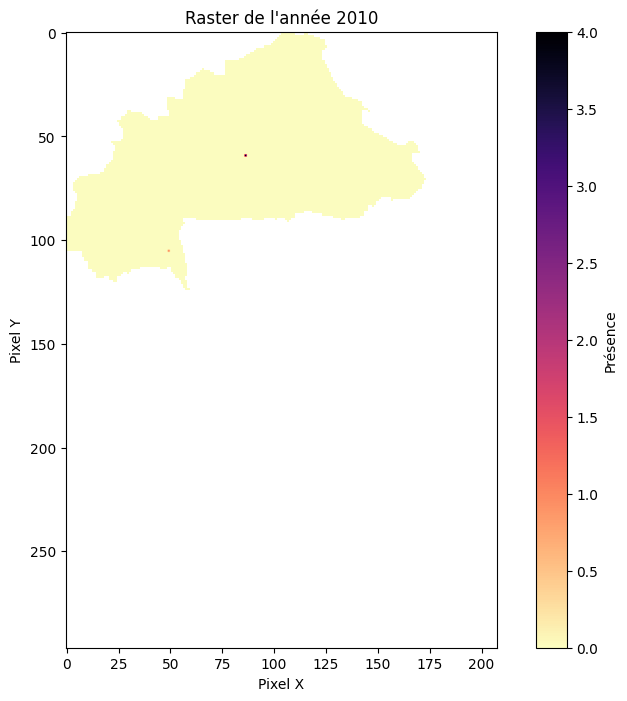

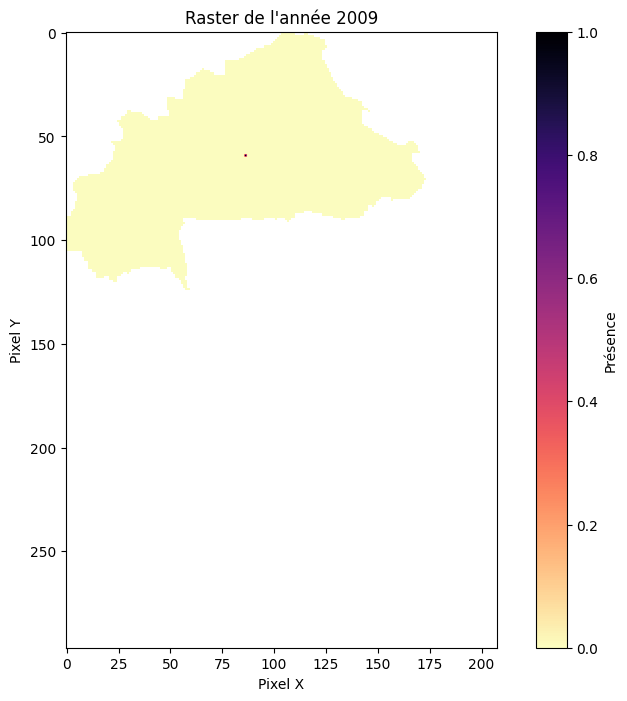

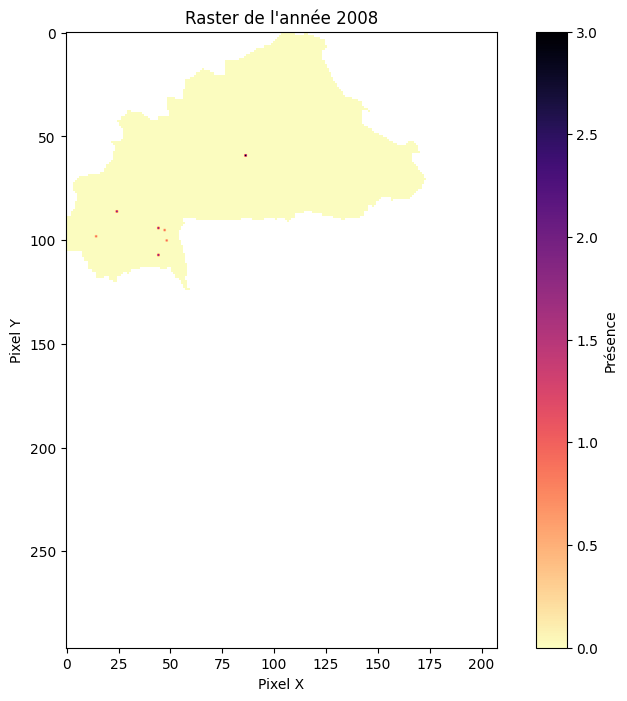

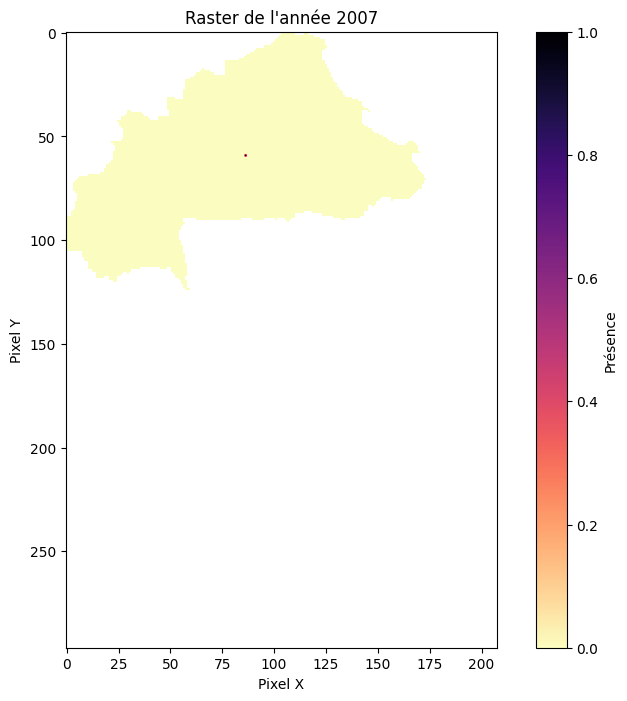

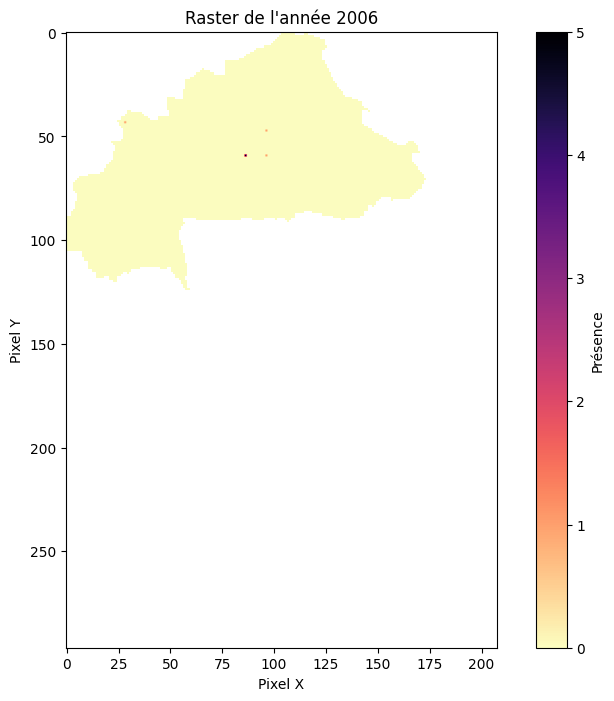

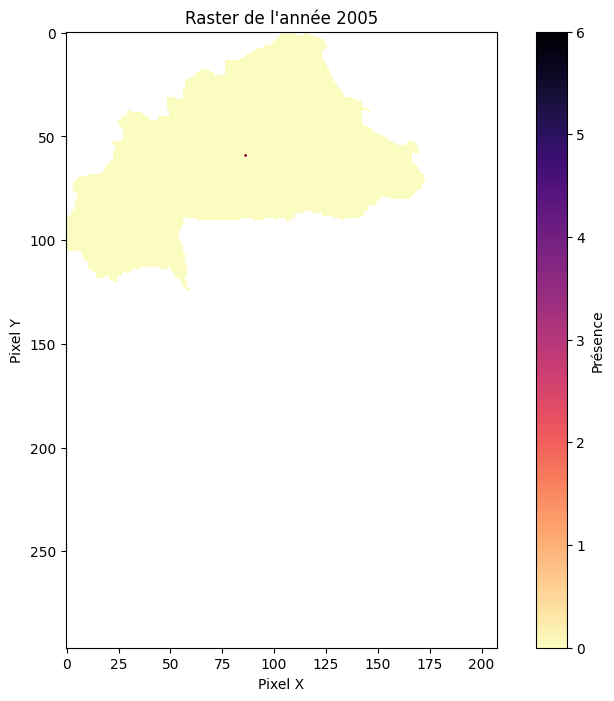

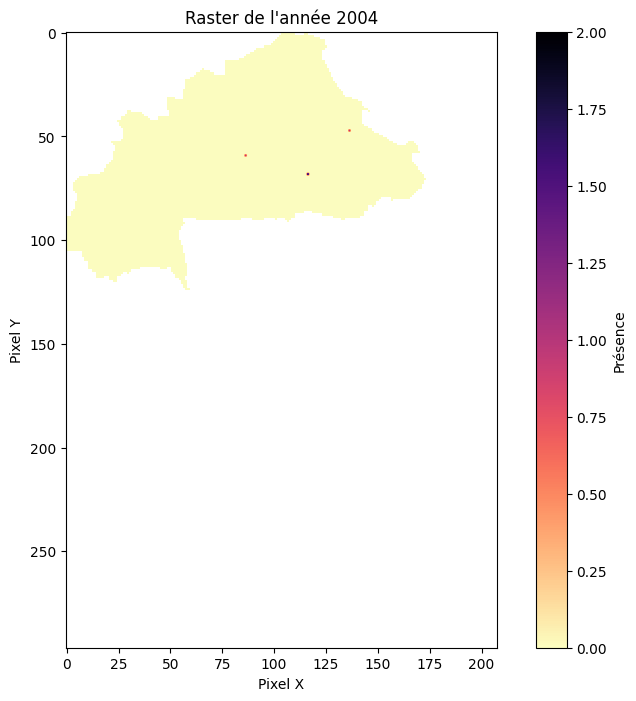

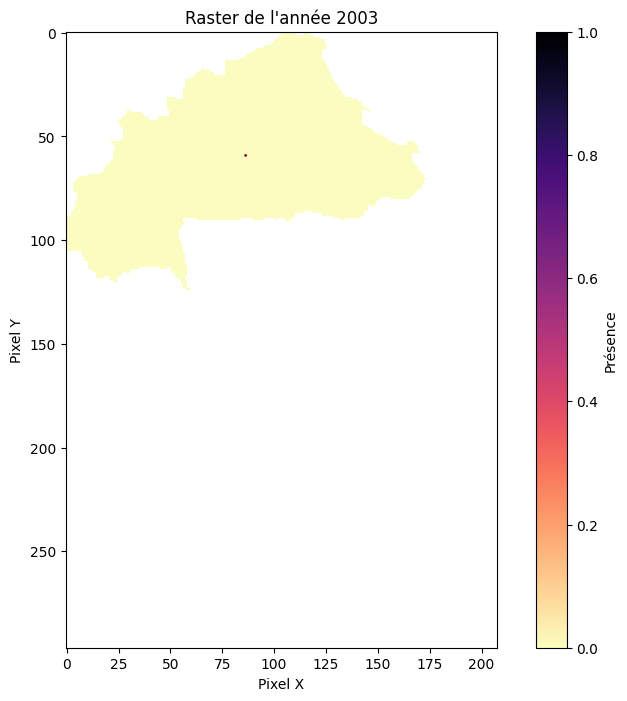

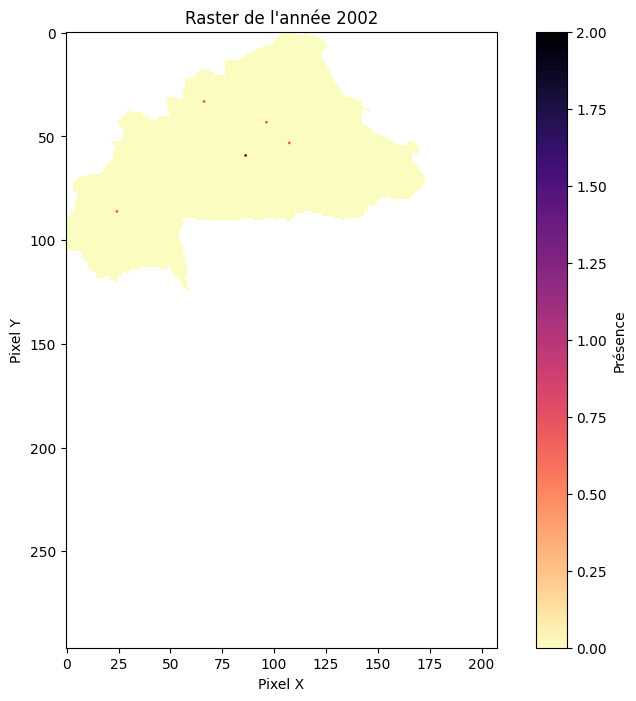

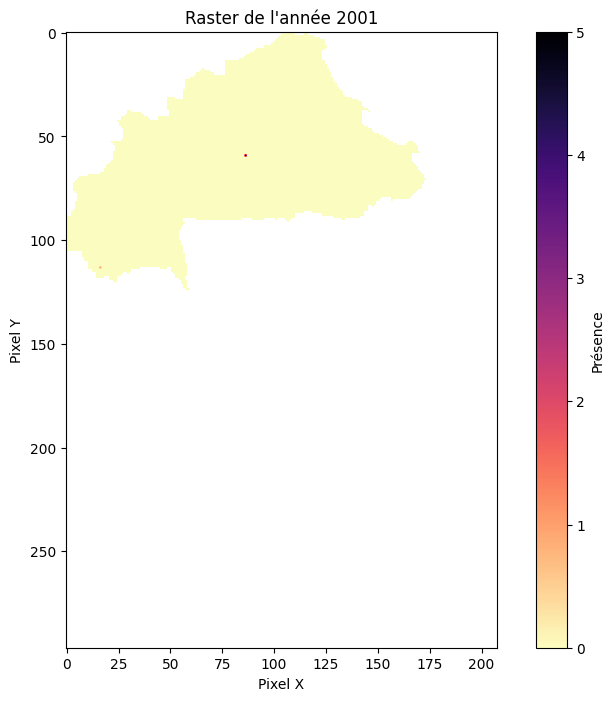

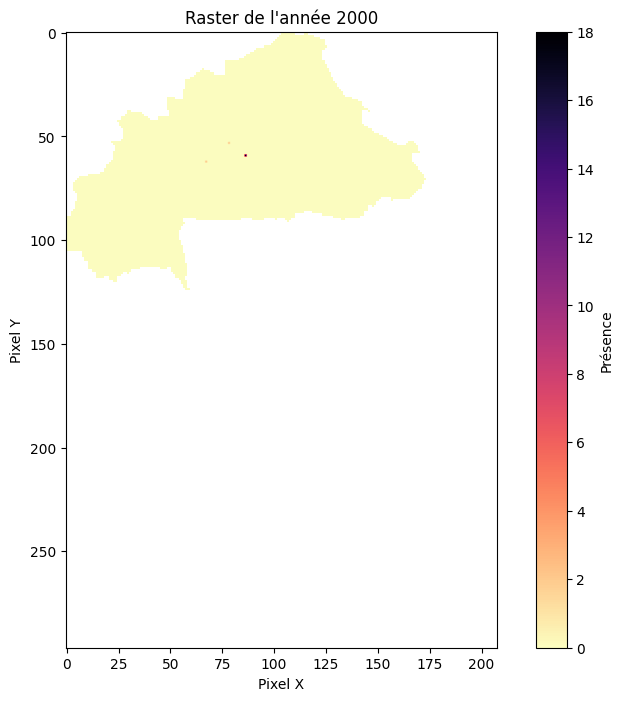

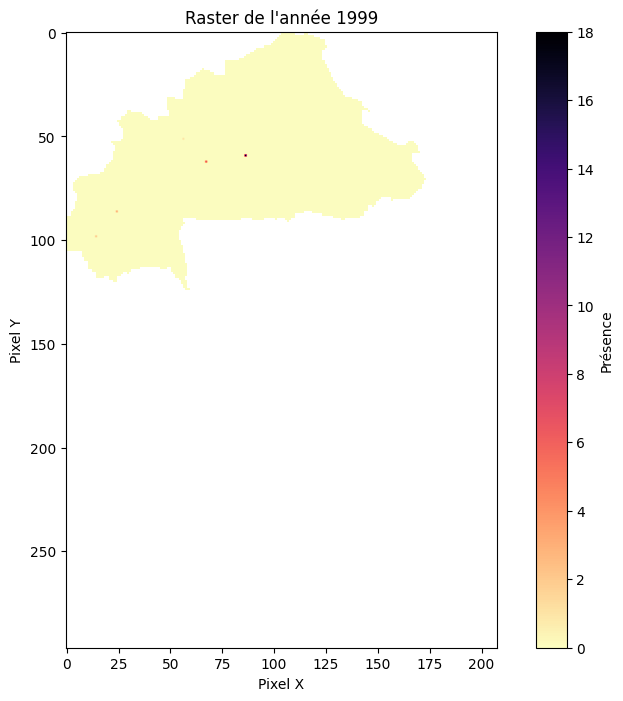

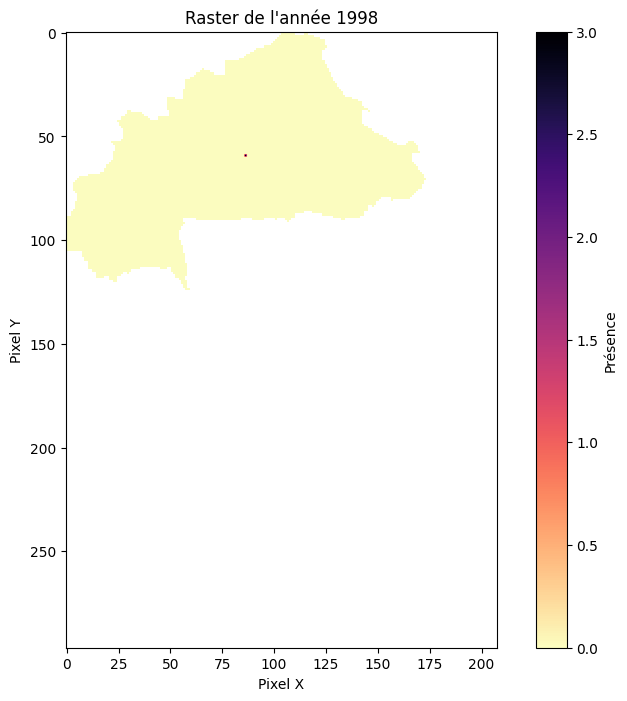

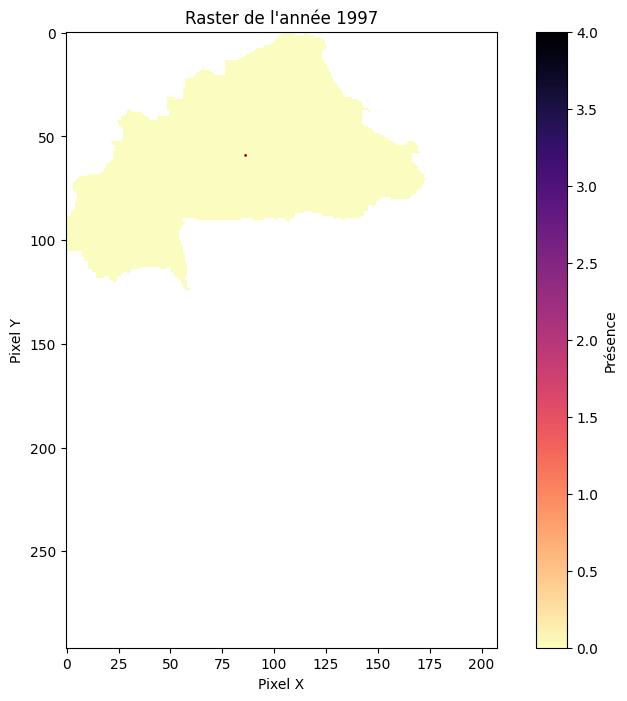

In [89]:
# Fonction pour visualiser un raster

def visualiser_raster(chemin_raster, titre, cmap='magma_r'):
    with rasterio.open(chemin_raster) as src:
        # Reprojeter le shapefile si nécessaire
        shapefile = gpd.read_file(chemin_shapefile)
        if shapefile.crs != crs:
            shapefile = shapefile.to_crs(crs)
            print("Shapefile reprojeté pour correspondre au CRS du raster.")
        
        geometries = shapefile.geometry.values  # Extraire les géométries
        
        # Créer un masque où les pixels à l'intérieur du shapefile sont True
        mask = geometry_mask(
        geometries,
        transform=transform,
        invert=True,
        out_shape=(src.height, src.width)
        )
        data=src.read(1)
        
    # Appliquer le masque au raster
        
        nom_data = np.where(mask, data, np.nan)  # Mettre NaN en dehors du shapefile
        
        data = src.read(1)
        plt.figure(figsize=(10, 8))
        plt.imshow(nom_data, cmap=cmap)
        plt.title(titre)
        plt.colorbar(label="Présence")
        plt.xlabel("Pixel X")
        plt.ylabel("Pixel Y")
        plt.show()

# Boucle pour visualiser chaque raster
for year in years:
    visualiser_raster(f'raster_{year}.tif', f'Raster de l\'année {year}')

### ***Visualisons l'évolution des évènements des rasters***

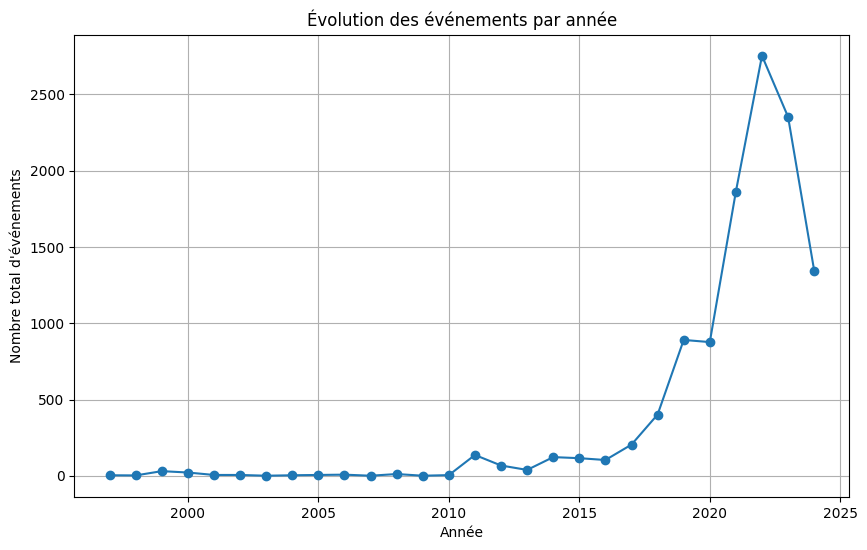

In [91]:
event_counts = {year: np.sum(rasters[year]) for year in years}

plt.figure(figsize=(10, 6))
plt.plot(sorted(event_counts.keys()), [event_counts[year] for year in sorted(event_counts.keys())], marker='o')
plt.title("Évolution des événements par année")
plt.xlabel("Année")
plt.ylabel("Nombre total d'événements")
plt.grid(True)
plt.show()


# Fin du TP6 ++